In [7]:
# Creating some simulated data for our example
import pandas as pd
import numpy as np
num_users = 10000
num_months = 12

signup_months = np.random.choice(np.arange(1, num_months), num_users) * np.random.randint(0,2, size=num_users) # signup_months == 0 means customer did not sign up
df = pd.DataFrame({
    'user_id': np.repeat(np.arange(num_users), num_months),
    'signup_month': np.repeat(signup_months, num_months), # signup month == 0 means customer did not sign up
    'month': np.tile(np.arange(1, num_months+1), num_users), # months are from 1 to 12
    'spend': np.random.poisson(500, num_users*num_months) #np.random.beta(a=2, b=5, size=num_users * num_months)*1000 # centered at 500
})
# A customer is in the treatment group if and only if they signed up
df["treatment"] = df["signup_month"]>0
# Simulating an effect of month (monotonically decreasing--customers buy less later in the year)
df["spend"] = df["spend"] - df["month"]*10
# Simulating a simple treatment effect of 100
after_signup = (df["signup_month"] < df["month"]) & (df["treatment"])
df.loc[after_signup,"spend"] = df[after_signup]["spend"] + 100
df

,user_id,signup_month,month,spend,treatment
0,0,0,1,476,False
1,0,0,2,470,False
2,0,0,3,432,False
3,0,0,4,460,False
4,0,0,5,451,False
...,...,...,...,...,...
119995,9999,0,8,423,False
119996,9999,0,9,403,False
119997,9999,0,10,437,False
119998,9999,0,11,361,False


In [9]:
import dowhy

# Setting the signup month (for ease of analysis)
i = 3

      user_id  signup_month  treatment  pre_spends  post_spends
0           0             0      False       473.0   424.666667
1           1             0      False       491.0   418.444444
2           2             0      False       505.0   410.333333
3           4             0      False       500.0   416.666667
4           6             3       True       491.5   515.555556
...       ...           ...        ...         ...          ...
5530     9991             3       True       476.0   510.222222
5531     9994             0      False       496.0   407.111111
5532     9995             0      False       486.5   411.777778
5533     9997             0      False       474.0   416.555556
5534     9999             0      False       488.5   420.666667

[5535 rows x 5 columns]


C:\Users\eddieliang\anaconda3\envs\ai\Lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


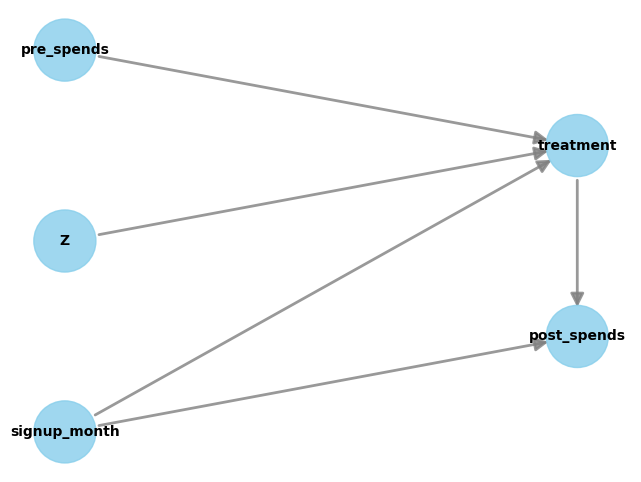

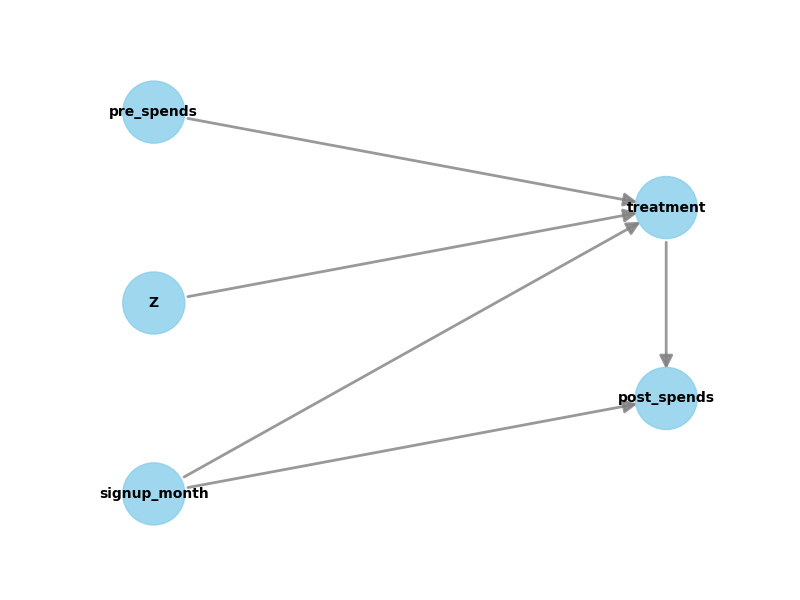

In [10]:
causal_graph = """digraph {
treatment[label="Program Signup in month i"];
pre_spends;
post_spends;
Z->treatment;
pre_spends -> treatment;
treatment->post_spends;
signup_month->post_spends;
signup_month->treatment;
}"""

# Post-process the data based on the graph and the month of the treatment (signup)
# For each customer, determine their average monthly spend before and after month i
df_i_signupmonth = (
    df[df.signup_month.isin([0, i])]
    .groupby(["user_id", "signup_month", "treatment"])
    .apply(
        lambda x: pd.Series(
            {
                "pre_spends": x.loc[x.month < i, "spend"].mean(),
                "post_spends": x.loc[x.month > i, "spend"].mean(),
            }
        )
    )
    .reset_index()
)
print(df_i_signupmonth)
model = dowhy.CausalModel(data=df_i_signupmonth,
                     graph=causal_graph.replace("\n", " "),
                     treatment="treatment",
                     outcome="post_spends")
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [16]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                             -1⎤
 ⎢       d                      ⎛       d                     ⎞  ⎥
E⎢────────────────(post_spends)⋅⎜────────────────([treatment])⎟  ⎥
 ⎣d[pre_spends  Z]              ⎝d[pre_spends  Z]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→post_spends then ¬(U →→{pre_spends,Z})
Estimand assumption 2, Exclusion: If we remove {pre_spends,Z}→{treatment}, then ¬({pre_spends,Z}→post_spends)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [17]:
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="iv.propensity_score_matching",
                                target_units="att")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                                             -1⎤
 ⎢       d                      ⎛       d                     ⎞  ⎥
E⎢────────────────(post_spends)⋅⎜────────────────([treatment])⎟  ⎥
 ⎣d[pre_spends  Z]              ⎝d[pre_spends  Z]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→post_spends then ¬(U →→{pre_spends,Z})
Estimand assumption 2, Exclusion: If we remove {pre_spends,Z}→{treatment}, then ¬({pre_spends,Z}→post_spends)

## Realized estimand
b: post_spends~treatment+signup_month
Target units: att

## Estimate
Mean value: 95.31133786848073



Indices of the two numbers whose sum is equal to the target: [0, 1]


In [29]:
nums1 = [7,6,5,4,3,2,1]
n = len(nums1)
for i in range(n-1):
    for j in range(n-i-1):  # Last i elements are already in place
        if nums1[j] > nums1[j+1]:
            nums1[j], nums1[j+1] = nums1[j+1], nums1[j]
nums

[1, 2, 3, 4, 5, 6, 7]

In [15]:
from collections import Counter
num ="444947137"

count = {}
for n in num:
    if n in count:
        count[n] += 1
    else:
        count[n] = 1

# palindrome = mid = ''

# for d in sorted(count.keys(), reverse=True):
#     mid = max(mid, d * (count[d] & 1))
#     palindrome += d * (count[d] // 2)

# palindrome = palindrome.lstrip('0')
# (palindrome + mid + palindrome[::-1]) or '0'

count

{'4': 4, '9': 1, '7': 2, '1': 1, '3': 1}

In [16]:
sorted(count.keys(), reverse=True)

['9', '7', '4', '3', '1']

In [24]:
5//2

2

In [25]:
int('-1')

-1